<a href="https://colab.research.google.com/github/Ronokhasan8781/CNN-Code/blob/main/95%25%20Gastric_Class_Detc_Pred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'gastric:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F5769059%2F9483807%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240926%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240926T075226Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D31bf2c070e07d1291dc5cd4d06a395d4b28c9091067d73ae7c471aecabc40ede4834ef0777de4c58fd8f1776158a40b5de3cfc1edbcb84d14fb3a376d0a3626d538bb47d2e366e22c4a47bce2b2546fa43372d09d42ae1eff9ff13e44352b4d3a0452d89adf9be31ab21511a2e92ddd39c705c7d588d94575d30799ade5c3dfb3947f319fe377f7c630648dc1ff6ef7709b734886d9cccb98805c74573e21d1bbdd0d3fc7c83bcfd215f8f2d8450437b706fb6c6aa3884994e581823f370cd13ae3c15559851a3553c9f67cbaf716753f3357f55f45980ec1c642d2b25bb5891d9389a6dd7d6dc1d7d71d5e6a0e8b85b25bbff596ebe8a0d3fa961f94f8cee7a'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


In [ ]:
# For Data Processing
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image, ImageEnhance

# For ML Models
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.models import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing.image import load_img

# For Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Miscellaneous
from tqdm import tqdm
import os
import random

In [ ]:
import os
from sklearn.utils import shuffle

# Directories
train_dir = '/kaggle/input/gastric/train/'
test_dir = '/kaggle/input/gastric/test/'

# Ensure the paths end with a slash
train_paths = []
train_labels = []

# Loop through each label (subdirectory) in the train_dir
for label in os.listdir(train_dir):
    label_dir = os.path.join(train_dir, label)  # Correctly join paths
    if os.path.isdir(label_dir):  # Ensure it's a directory, not a file
        for image in os.listdir(label_dir):
            train_paths.append(os.path.join(label_dir, image))  # Correctly join paths
            train_labels.append(label)

# Shuffle the paths and labels together
train_paths, train_labels = shuffle(train_paths, train_labels)

# Print a sample to verify the paths
print(train_paths[:5])
print(train_labels[:5])


['/kaggle/input/gastric/train/0_normal/val_normal_ (62).jpg', '/kaggle/input/gastric/train/3_esophagitis/train_esophagitis_ (341).jpg', '/kaggle/input/gastric/train/3_esophagitis/val_esophagitis_ (91).jpg', '/kaggle/input/gastric/train/0_normal/train_normal_ (109).jpg', '/kaggle/input/gastric/train/0_normal/train_normal_ (485).jpg']
['0_normal', '3_esophagitis', '3_esophagitis', '0_normal', '0_normal']


In [ ]:
train_dir = '/kaggle/input/gastric/train'
test_dir = '/kaggle/input/gastric/test'

train_paths = []
train_labels = []

for label in os.listdir(train_dir):
    for image in os.listdir(train_dir+label):
        train_paths.append(train_dir+label+'/'+image)
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/gastric/train0_normal'

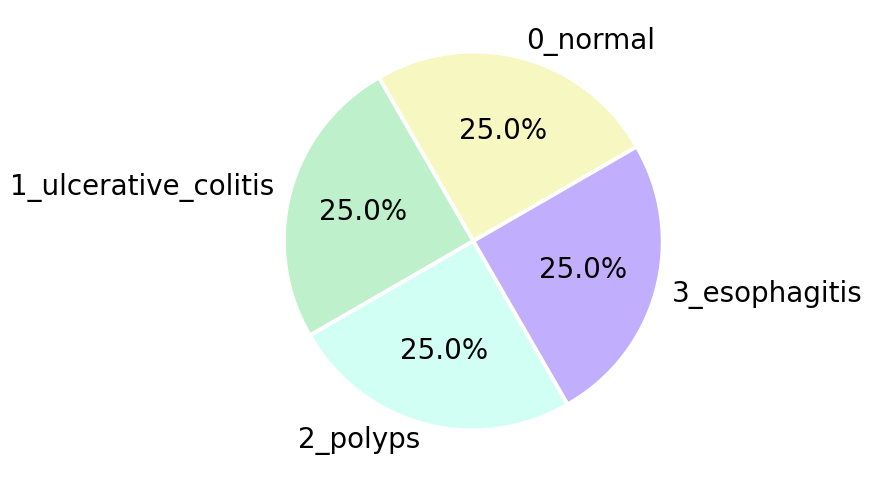

In [ ]:
plt.figure(figsize=(14,6))
colors = ['#F6F7C1', '#BEF0CB', '#D1FFF3', '#C1AEFC']
plt.rcParams.update({'font.size': 20})
plt.pie([len([x for x in train_labels if x=='0_normal']),
         len([x for x in train_labels if x=='1_ulcerative_colitis']),
         len([x for x in train_labels if x=='2_polyps']),
         len([x for x in train_labels if x=='3_esophagitis'])],
        labels=['0_normal','1_ulcerative_colitis', '2_polyps', '3_esophagitis'],
        colors=colors, autopct='%.1f%%', explode=(0.015,0.015,0.015,0.015),
        startangle=30);

In [ ]:
test_paths = []
test_labels = []

for label in os.listdir(test_dir):
    for image in os.listdir(test_dir+label):
        test_paths.append(test_dir+label+'/'+image)
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

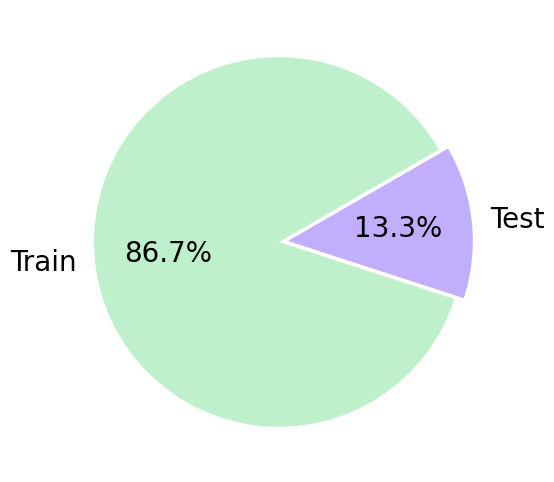

In [ ]:
plt.figure(figsize=(14,6))
colors = ['#BEF0CB', '#C1AEFC']
plt.rcParams.update({'font.size': 20})
plt.pie([len(train_labels), len(test_labels)],
        labels=['Train','Test'],
        colors=colors, autopct='%.1f%%', explode=(0.05,0),
        startangle=30);

In [ ]:
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8,1.2))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8,1.2))
    image = np.array(image)/255.0
    return image

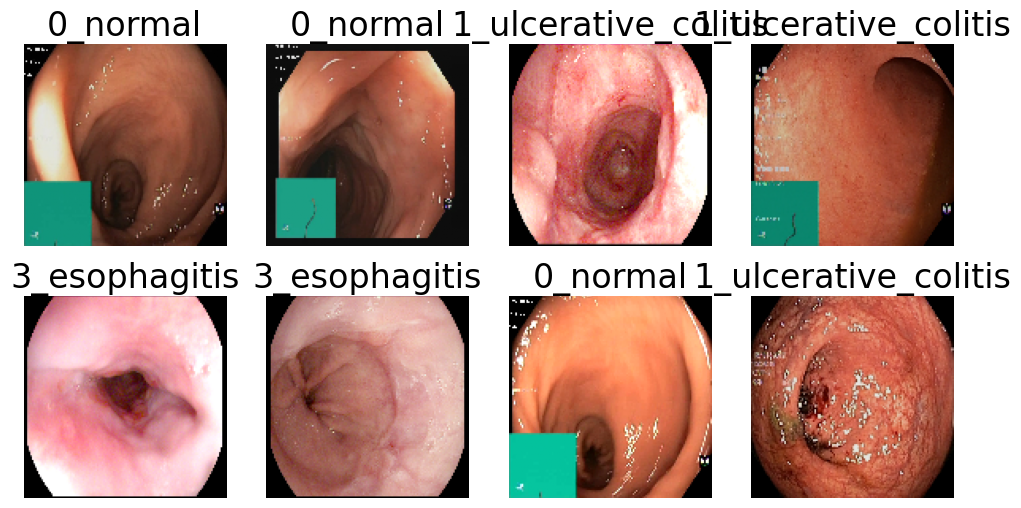

In [ ]:
IMAGE_SIZE = 128

def open_images(paths):
    '''
    Given a list of paths to images, this function returns the images as arrays (after augmenting them)
    '''
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE,IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
    return np.array(images)

images = open_images(train_paths[50:59])
labels = train_labels[50:59]
fig = plt.figure(figsize=(12, 6))
for x in range(1, 9):
    fig.add_subplot(2, 4, x)
    plt.axis('off')
    plt.title(labels[x])
    plt.imshow(images[x])
plt.rcParams.update({'font.size': 20})
plt.show()

In [ ]:
unique_labels = os.listdir(train_dir)

def encode_label(labels):
    encoded = []
    for x in labels:
        encoded.append(unique_labels.index(x))
    return np.array(encoded)

def decode_label(labels):
    decoded = []
    for x in labels:
        decoded.append(unique_labels[x])
    return np.array(decoded)

def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for x in range(0, len(paths), batch_size):
            batch_paths = paths[x:x+batch_size]
            batch_images = open_images(batch_paths)
            batch_labels = labels[x:x+batch_size]
            batch_labels = encode_label(batch_labels)
            yield batch_images, batch_labels

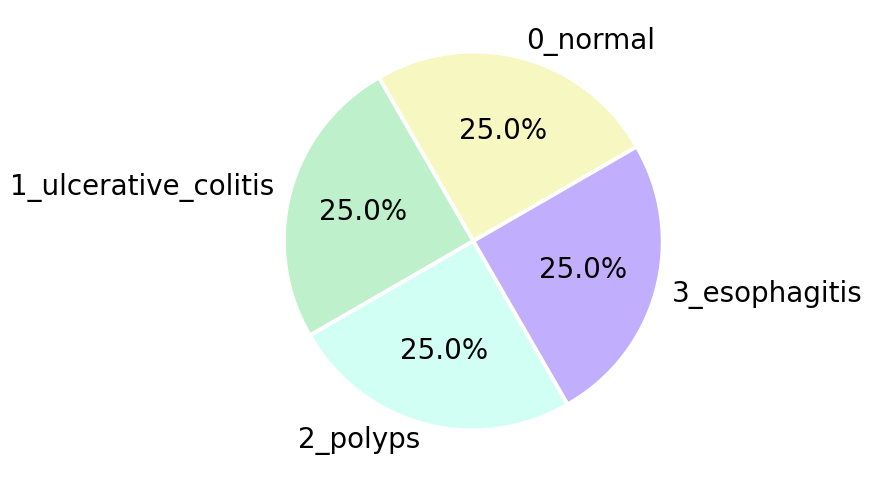

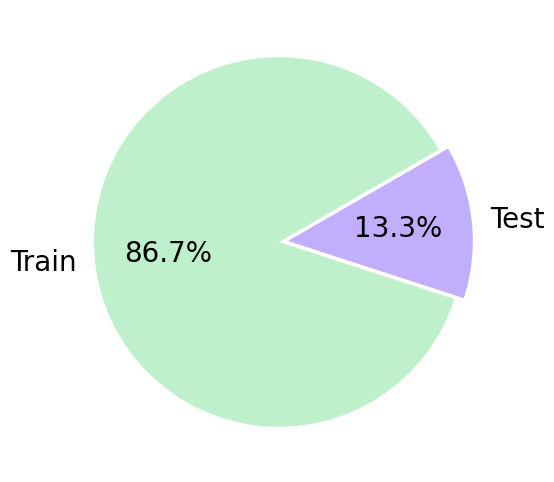

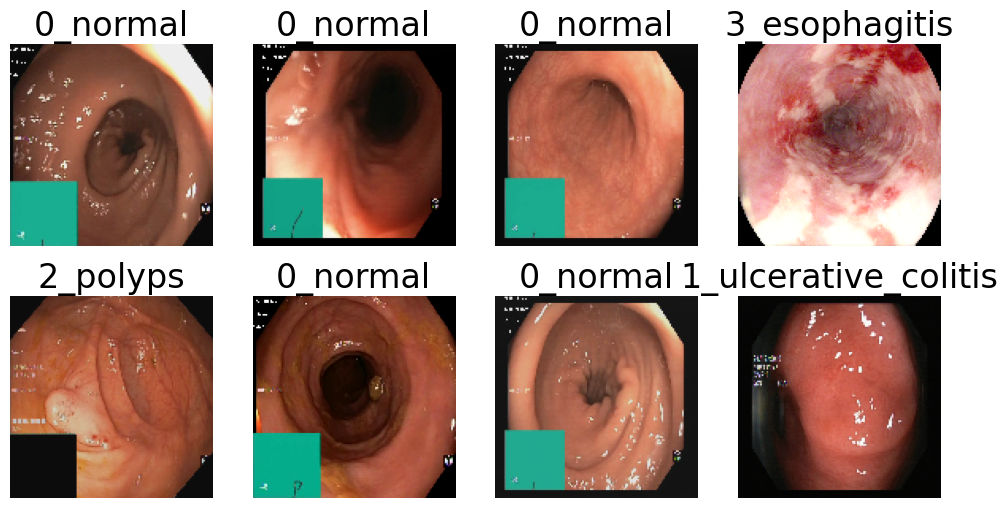

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 4, 4, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,782,660 (105.98 MB)

 Trainable params: 13,126,276 (50.07 MB)

 Non-trainable params: 14,656,384 (55.91 MB)

Epoch 1/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 51s 320ms/step - loss: 0.8829 - sparse_categorical_accuracy: 0.6335
Epoch 2/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 42s 316ms/step - loss: 0.3054 - sparse_categorical_accuracy: 0.8836
Epoch 3/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 37s 320ms/step - loss: 0.2268 - sparse_categorical_accuracy: 0.9107
Epoch 4/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 37s 324ms/step - loss: 0.1742 - sparse_categorical_accuracy: 0.9346
Epoch 5/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 37s 322ms/step - loss: 0.1483 - sparse_categorical_accuracy: 0.9429
Epoch 6/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 37s 323ms/step - loss: 0.1372 - sparse_categorical_accuracy: 0.9447
Epoch 7/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 37s 319ms/step - loss: 0.1178 - sparse_categorical_accuracy: 0.9560
Epoch 8/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 37s 325ms/step - loss: 0.1001 - sparse_categorical_accuracy: 0.9619
Epoch 9/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 37s 324ms/step - loss: 0.0885 - sparse_categorical_accuracy: 0.9659
Epoch 10/50
115/115 ━━━━━━━━

In [ ]:
import os
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from PIL import Image, ImageEnhance
from keras.preprocessing.image import load_img
from keras.applications import ResNet50
from keras.models import Sequential
from keras.layers import Input, Flatten, Dropout, Dense
from keras.optimizers import Adam

# Directories
train_dir = '/kaggle/input/gastric/train/'
test_dir = '/kaggle/input/gastric/test/'

# Load training paths and labels
train_paths = []
train_labels = []

for label in os.listdir(train_dir):
    label_dir = os.path.join(train_dir, label)  # Correctly join the path
    for image in os.listdir(label_dir):
        train_paths.append(os.path.join(label_dir, image))  # Correctly join the path
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

# Visualize class distribution
plt.figure(figsize=(14, 6))
colors = ['#F6F7C1', '#BEF0CB', '#D1FFF3', '#C1AEFC']
plt.rcParams.update({'font.size': 20})
plt.pie([len([x for x in train_labels if x == '0_normal']),
         len([x for x in train_labels if x == '1_ulcerative_colitis']),
         len([x for x in train_labels if x == '2_polyps']),
         len([x for x in train_labels if x == '3_esophagitis'])],
        labels=['0_normal', '1_ulcerative_colitis', '2_polyps', '3_esophagitis'],
        colors=colors, autopct='%.1f%%', explode=(0.015, 0.015, 0.015, 0.015),
        startangle=30)

# Load testing paths and labels
test_paths = []
test_labels = []

for label in os.listdir(test_dir):
    label_dir = os.path.join(test_dir, label)  # Correctly join the path
    for image in os.listdir(label_dir):
        test_paths.append(os.path.join(label_dir, image))  # Correctly join the path
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

# Visualize training and testing data distribution
plt.figure(figsize=(14, 6))
colors = ['#BEF0CB', '#C1AEFC']
plt.rcParams.update({'font.size': 20})
plt.pie([len(train_labels), len(test_labels)],
        labels=['Train', 'Test'],
        colors=colors, autopct='%.1f%%', explode=(0.05, 0),
        startangle=30)

# Image augmentation function
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))
    image = np.array(image) / 255.0
    return image

IMAGE_SIZE = 128

# Function to load images
def open_images(paths):
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
    return np.array(images)

# Visualize some images
images = open_images(train_paths[50:59])
labels = train_labels[50:59]
fig = plt.figure(figsize=(12, 6))
for x in range(1, 9):
    fig.add_subplot(2, 4, x)
    plt.axis('off')
    plt.title(labels[x])
    plt.imshow(images[x])
plt.rcParams.update({'font.size': 20})
plt.show()

# Get unique labels
unique_labels = os.listdir(train_dir)

# Label encoding and decoding functions
def encode_label(labels):
    encoded = []
    for x in labels:
        encoded.append(unique_labels.index(x))
    return np.array(encoded)

def decode_label(labels):
    decoded = []
    for x in labels:
        decoded.append(unique_labels[x])
    return np.array(decoded)

# Data generator function
def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for x in range(0, len(paths), batch_size):
            batch_paths = paths[x:x + batch_size]
            batch_images = open_images(batch_paths)
            batch_labels = labels[x:x + batch_size]
            batch_labels = encode_label(batch_labels)
            yield batch_images, batch_labels

# Load ResNet50 model
base_model = ResNet50(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')

# Set layers to non-trainable
for layer in base_model.layers:
    layer.trainable = False

# Set the last few blocks to trainable if desired
for layer in base_model.layers[-20:]:  # Adjust the number of layers to fine-tune as needed
    layer.trainable = True

# Build the model
model = Sequential()
model.add(Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(unique_labels), activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.00001),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

# Print the model summary
model.summary()

# Training parameters
batch_size = 45
steps = int(len(train_paths) / batch_size)
epochs = 50

# Train the model
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)


In [ ]:
# Import necessary libraries
import numpy as np
import os
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from tqdm import tqdm
from PIL import Image, ImageEnhance

# Directories
train_dir = '/kaggle/input/gastric/train/'
test_dir = '/kaggle/input/gastric/test/'

# Load training paths and labels
train_paths = []
train_labels = []
for label in os.listdir(train_dir):
    label_dir = os.path.join(train_dir, label)  # Correctly join directory path and label
    for image in os.listdir(label_dir):
        train_paths.append(os.path.join(label_dir, image))  # Correctly join the image path
        train_labels.append(label)
train_paths, train_labels = shuffle(train_paths, train_labels)

# Load testing paths and labels
test_paths = []
test_labels = []
for label in os.listdir(test_dir):
    label_dir = os.path.join(test_dir, label)  # Correctly join directory path and label
    for image in os.listdir(label_dir):
        test_paths.append(os.path.join(label_dir, image))  # Correctly join the image path
        test_labels.append(label)
test_paths, test_labels = shuffle(test_paths, test_labels)

# Define image size
IMAGE_SIZE = 128

# Image augmentation function
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))
    image = np.array(image) / 255.0
    return image

# Function to load images
def open_images(paths):
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
    return np.array(images)

# Get unique labels
unique_labels = os.listdir(train_dir)

# Label encoding and decoding functions
def encode_label(labels):
    return np.array([unique_labels.index(x) for x in labels])

def decode_label(labels):
    return np.array([unique_labels[x] for x in labels])

# Data generator function
def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for x in range(0, len(paths), batch_size):
            batch_paths = paths[x:x + batch_size]
            batch_images = open_images(batch_paths)
            batch_labels = labels[x:x + batch_size]
            batch_labels = encode_label(batch_labels)
            yield batch_images, batch_labels

# Load ResNet50 model
base_model = ResNet50(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')
for layer in base_model.layers:
    layer.trainable = False
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Build the model
def create_model():
    model = Sequential([
        Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
        base_model,
        GlobalAveragePooling2D(),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(len(unique_labels), activation='softmax')
    ])
    return model

# Create the model and compile
model = create_model()
model.compile(optimizer=Adam(learning_rate=0.00001),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

# Print the model summary
model.summary()

# Training parameters
batch_size = 34
steps = int(len(train_paths) / batch_size)
epochs = 25

# Train the model
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

# Define the clients and their data for federated learning
NUM_CLIENTS = 5
NUM_ROUNDS = 3
clients = []
for i in range(NUM_CLIENTS):
    client_data = train_paths[i * (len(train_paths) // NUM_CLIENTS):(i + 1) * (len(train_paths) // NUM_CLIENTS)]
    client_labels = train_labels[i * (len(train_labels) // NUM_CLIENTS):(i + 1) * (len(train_labels) // NUM_CLIENTS)]
    clients.append((client_data, client_labels))

# Federated learning loop
global_weights = model.get_weights()  # Initial global weights

for round_num in range(NUM_ROUNDS):
    print(f"Round {round_num + 1}/{NUM_ROUNDS}")

    # Select clients
    selected_client_indices = np.random.choice(len(clients), size=int(NUM_CLIENTS * 0.5), replace=False)
    selected_clients = [clients[i] for i in selected_client_indices]

    # Transmit the global model to the selected clients
    for client_data, client_labels in selected_clients:
        # Clone the global model architecture
        client_model = create_model()
        client_model.set_weights(global_weights)  # Load global weights into client model

        # Compile the client model
        client_model.compile(optimizer=Adam(learning_rate=0.00001),
                             loss='sparse_categorical_crossentropy',
                             metrics=['sparse_categorical_accuracy'])

        steps_per_epoch = int(len(client_data) / batch_size)

        # Train locally
        client_model.fit(datagen(client_data, client_labels, batch_size=batch_size, epochs=5),
                         epochs=5, steps_per_epoch=steps_per_epoch)

        # After local training, get client model weights
        client_weights = client_model.get_weights()

        # Aggregate the weights from client model with global model weights
        new_weights = []
        for layer_index in range(len(global_weights)):
            new_layer_weights = np.mean([client_weights[layer_index], global_weights[layer_index]], axis=0)
            new_weights.append(new_layer_weights)

        # Update the global model weights
        global_weights = new_weights

    # Update the global model with new weights
    model.set_weights(global_weights)

# Evaluate on test data
batch_size = 45
steps = int(len(test_paths) / batch_size)
y_pred = []
y_true = []
for x, y in tqdm(datagen(test_paths, test_labels, batch_size=batch_size, epochs=1), total=steps):
    pred = model.predict(x)
    pred = np.argmax(pred, axis=-1)
    y_pred.extend(decode_label(pred))
    y_true.extend(decode_label(y))

# Save the model
model.save('my_model.h5')


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 4, 4, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,850,500 (90.98 MB)

 Trainable params: 9,194,116 (35.07 MB)

 Non-trainable params: 14,656,384 (55.91 MB)

Epoch 1/25
152/152 ━━━━━━━━━━━━━━━━━━━━ 55s 258ms/step - loss: 1.0030 - sparse_categorical_accuracy: 0.5652
Epoch 2/25
152/152 ━━━━━━━━━━━━━━━━━━━━ 45s 245ms/step - loss: 0.3876 - sparse_categorical_accuracy: 0.8603
Epoch 3/25
152/152 ━━━━━━━━━━━━━━━━━━━━ 38s 248ms/step - loss: 0.2625 - sparse_categorical_accuracy: 0.9061
Epoch 4/25
152/152 ━━━━━━━━━━━━━━━━━━━━ 37s 245ms/step - loss: 0.2057 - sparse_categorical_accuracy: 0.9265
Epoch 5/25
152/152 ━━━━━━━━━━━━━━━━━━━━ 37s 245ms/step - loss: 0.1712 - sparse_categorical_accuracy: 0.9356
Epoch 6/25
152/152 ━━━━━━━━━━━━━━━━━━━━ 38s 253ms/step - loss: 0.1420 - sparse_categorical_accuracy: 0.9471
Epoch 7/25
152/152 ━━━━━━━━━━━━━━━━━━━━ 38s 251ms/step - loss: 0.1151 - sparse_categorical_accuracy: 0.9578
Epoch 8/25
152/152 ━━━━━━━━━━━━━━━━━━━━ 39s 254ms/step - loss: 0.0975 - sparse_categorical_accuracy: 0.9650
Epoch 9/25
152/152 ━━━━━━━━━━━━━━━━━━━━ 39s 256ms/step - loss: 0.0854 - sparse_categorical_accuracy: 0.9721
Epoch 10/25
152/152 ━━━━━━━━

  0%|          | 0/17 [00:00<?, ?it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 4s/step


  6%|▌         | 1/17 [00:07<02:04,  7.81s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 12%|█▏        | 2/17 [00:08<00:54,  3.63s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 18%|█▊        | 3/17 [00:09<00:32,  2.29s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 24%|██▎       | 4/17 [00:09<00:21,  1.66s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 29%|██▉       | 5/17 [00:10<00:15,  1.31s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|███▌      | 6/17 [00:11<00:11,  1.09s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 41%|████      | 7/17 [00:11<00:09,  1.03it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 47%|████▋     | 8/17 [00:12<00:07,  1.13it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|█████▎    | 9/17 [00:13<00:06,  1.17it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 59%|█████▉    | 10/17 [00:14<00:05,  1.23it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 65%|██████▍   | 11/17 [00:14<00:04,  1.26it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 71%|███████   | 12/17 [00:15<00:03,  1.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 76%|███████▋  | 13/17 [00:16<00:03,  1.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 82%|████████▏ | 14/17 [00:17<00:02,  1.35it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 88%|████████▊ | 15/17 [00:17<00:01,  1.34it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 94%|█████████▍| 16/17 [00:18<00:00,  1.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


100%|██████████| 17/17 [00:19<00:00,  1.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step 


18it [00:21,  1.22s/it]                        


In [ ]:
print(classification_report(y_true, y_pred))

                      precision    recall  f1-score   support

            0_normal       1.00      1.00      1.00       200
1_ulcerative_colitis       0.91      0.91      0.91       200
            2_polyps       0.91      0.90      0.91       200
       3_esophagitis       0.98      1.00      0.99       200

            accuracy                           0.95       800
           macro avg       0.95      0.95      0.95       800
        weighted avg       0.95      0.95      0.95       800



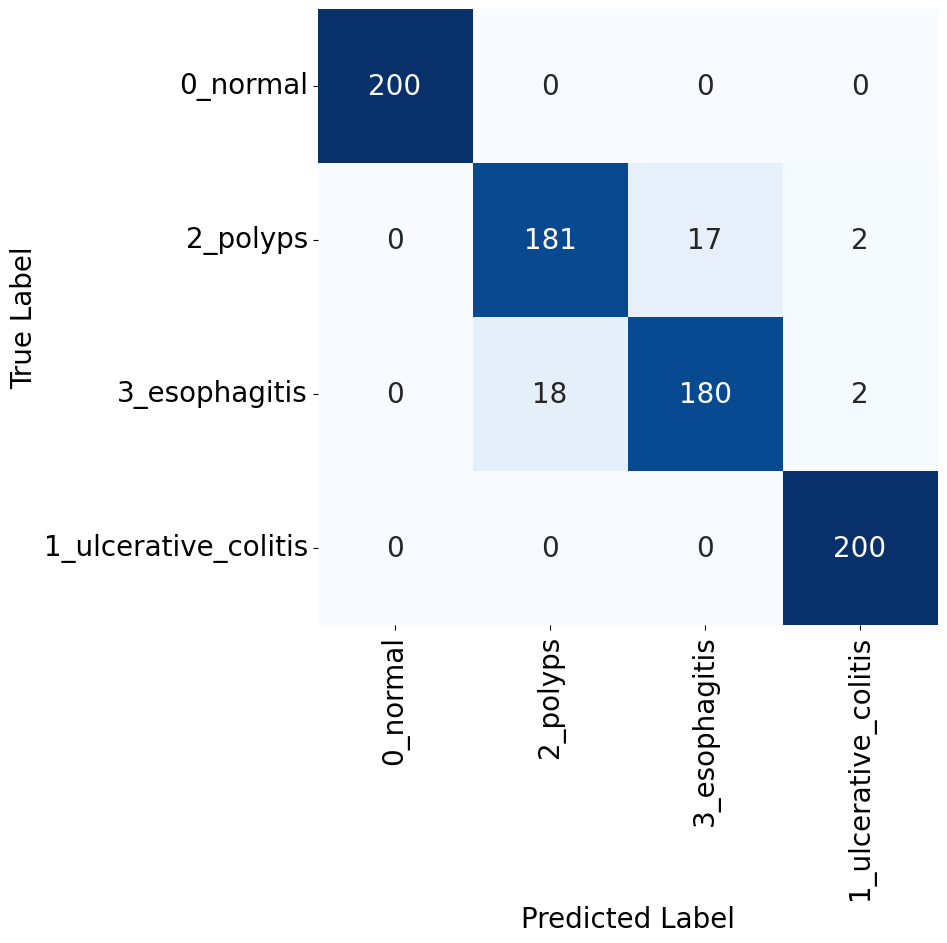

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np




cm = confusion_matrix(y_true, y_pred)

# Define the font size
font_size = 20

# Plot the confusion matrix
plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=unique_labels, yticklabels=unique_labels, annot_kws={"fontsize": font_size}, cbar=False)
plt.xlabel("Predicted Label", fontsize=font_size)
plt.ylabel("True Label", fontsize=font_size)
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size, rotation=0)
plt.show()

In [ ]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

KeyError: 'accuracy'